In [1]:
!pip install pydicom
import pydicom
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt 
from ipywidgets import widgets, interact
from IPython.display import clear_output, HTML, display
import datetime, time, os

from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.data import get_testdata_file

## DICOM

In [2]:
def save_dicom(filename,name,id,date,comment,img, sex, birth):
  from pydicom._storage_sopclass_uids import MRImageStorage
  
  meta = Dataset()
  meta.MediaStorageSOPClassUID = MRImageStorage
  meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
  meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

  ds = FileDataset(filename, {}, file_meta=meta, preamble=b"\0" * 128)
  ds.is_little_endian = True
  ds.is_implicit_VR = False
  ds.SOPClassUID = MRImageStorage

  ds.PatientName = name
  ds.PatientID = id
  ds.PatientSex = sex
  ds.PatientBirthDate = birth
  ds.StudyDescription = comment
  ds.StudyDate = date

  ds.Rows, ds.Columns = img.shape
  ds.PixelData =  (img*255).astype(np.uint16).tobytes()

  ds.Modality = 'MR'
  ds.SeriesInstanceUID = pydicom.uid.generate_uid()
  ds.StudyInstanceUID = pydicom.uid.generate_uid()
  ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

  ds.BitsStored = 16
  ds.BitsAllocated = 16
  ds.SamplesPerPixel = 1
  ds.HighBit = 15

  ds.ImagesInAcquisition = '1'
  ds.InstanceNumber = 1
  ds.ImagePositionPatient = r'0\0\1'
  ds.ImageOrientationPatient = r'1\0\0\0\-1\0'
  ds.ImageType = r'ORIGINAL\PRIMARY\AXIAL'
  ds.RescaleIntercept = '0'
  ds.RescaleSlope = '1'
  ds.PixelSpacing = r'1\1'
  ds.PhotometricInterpretation = 'MONOCHROME2'
  ds.PixelRepresentation = 1

  dt = datetime.datetime.now()
  ds.ContentDate = dt.strftime('%Y%m%d')
  timeStr = dt.strftime('%H%M%S.%f') 
  ds.ContentTime = timeStr

  pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
  ds.save_as('results/'+filename, write_like_original=False)

def read_dicom(file,all=False):
    try:
      dataset = pydicom.dcmread(file) 
      img = dataset.pixel_array
      if all:
        plt.imshow(img, cmap='gray')
        print(dataset)
      else:
        try:
          print(f"Patient's Name...: {dataset.PatientName}")
          print(f"Patient ID.......: {dataset.PatientID}")
          print(f"Patient's Sex....: {dataset.PatientSex}")
          print(f"Patient's Birth..: {dataset.PatientBirthDate}")
          print(f"Study Description: {dataset.StudyDescription}")
          print(f"Study Date.......: {dataset.StudyDate}")
        except: 
          pass

    except:
      print("Lack of information")

###Test DICOM

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.53575187965496282706695008859300396329
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.1.2'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0020) Study Date                          DA: '20210312'
(0008, 0023) Content Date                        DA: '20210328'
(0008, 0033) Content Time                        TM: '220450.504845'
(0008, 0

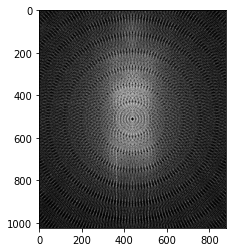

In [3]:
read_dicom('results/test.dcm',1)

# Interface

In [5]:
class color:
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   END = '\033[1;37;0m'

In [2]:
def show_image(img):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.show()

def bresenham_line(point0,point1):
    points=[]
    x0, y0 = point0
    x1, y1 = point1
    sx = 1 if x0<x1 else -1
    sy = 1 if y0<y1 else -1

    dx = abs(x1-x0)
    dy = -abs(y1-y0)
    
    err = dy + dx

    while True:
      points.append((x0,y0))
      if x0==x1 and y0==y1:
        return points

      e2 = 2*err
      if e2 > dy:
        err += dy
        x0 += sx
      if e2 < dx:
        err += dx
        y0 += sy

def calc_rmse(a, b):
    a = a/(np.max(a)-np.min(a))
    b = b/(np.max(b)-np.min(b))
    return np.sqrt( np.mean( (a-b)**2 ) )

def em_det_parallel(n,l,size):
    h, w = size
    r = math.sqrt(h**2 + w**2)//2

    l = int( 2*r *math.sin( (l*math.pi/180)/2 ) )
    x_left, x_right = h//2-l//2, h//2+l//2
    range =  np.linspace(x_left, x_right, n)

    emitters = [(pos_x, w//2 + r) for pos_x in range]
    detectors = [(pos_x, w//2 - r) for pos_x in range]
    return emitters, detectors

def rotate_line(line, center, angle):
    cx,cy = center
    rotated_line = []

    for point in line:
        x, y = point
        new_x = int( cx + math.cos(angle) * (x-cx) - math.sin(angle) * (y-cy) )
        new_y = int( cy + math.sin(angle) * (x-cx) + math.cos(angle) * (y-cy) )
        rotated_line.append((new_x,new_y))
    return rotated_line

def gen_kernel(size):
    kernel = []
    for i in range(-size//2, size//2):
        if i == 0:
            kernel.append(1)
        elif i % 2 == 0:
              kernel.append(0)
        elif i % 2 == 1:
            kernel.append( (-4/(math.pi**2)) /i**2)
    return kernel

def filter_sinogram(sinogram):
    filtered = np.zeros(sinogram.shape)
    for i in range(len(sinogram[0])):
        filtered[:,i] = np.convolve(sinogram[:,i], gen_kernel( len(sinogram[:,i]) ), mode = 'same')
    return filtered 

def gen_sinogram(n,deltaAlpha,l,img, iter):
    height, width  = img.shape
    cx, cy = height//2, width //2
    iterations = round(360/deltaAlpha)
    
    em, det = em_det_parallel(n, l, img.shape)
    lines = [bresenham_line(p0,p1) for p0, p1 in zip(em,det)]
    all_lines = []
    sinogram = np.zeros( (n, iterations) )
    all_sinogram = []

    for i in range(iterations):
        rotated_lines = []
        for line in lines:
            rot_line = rotate_line(line, ( cx, cy ), math.pi/180 * deltaAlpha * i )
            new_line = [(px,py) for px,py in rot_line if 0<px<height and 0<py<width ]
            rotated_lines.append(new_line)

        all_lines.append(rotated_lines)
        for j, line in enumerate(rotated_lines):
            sinogram[j][i] = np.sum([img[tuple(point)] for point in line])
              
        if (i+1) % iter == 0:
          all_sinogram.append( sinogram/ np.max(sinogram) )

    sinogram = sinogram / np.max(sinogram)  
    return all_sinogram, sinogram, all_lines

def reconstruct_image(sinogram, all_lines, image_size, iter):
    h, w = image_size
    rec_img = np.zeros((h,w))
    count_matrix = np.zeros((h,w))
    all_rec = []

    for x, alpha_line in enumerate(all_lines):
      for y, line in enumerate(alpha_line):
        for px, py in line:
            rec_img[px][py] += sinogram[y][x] 
            count_matrix[px][py] += 1
      if (x+1) % iter == 0:
        all_rec.append( rec_img / np.max(rec_img) )

    for i in range(len(count_matrix)):
      for j in range(len(count_matrix[0])):
          if count_matrix[i][j] != 0:
              rec_img[i][j] /= count_matrix[i][j]
      
    # lo, hi = np.percentile(rec_img, (2, 98))
    # copy = rec_img.copy()
    # rec_img[copy<=lo] = lo
    # rec_img[copy>=hi] = hi
    # rec_img = (rec_img - rec_img.min())/ rec_img.max()
    return all_rec, rec_img

## widgets initialization

In [7]:
images = [f"img/{file}" for file in os.listdir('img')]
images_dicom = [f"img_dicom/{file}" for file in os.listdir('img_dicom')]
images_result = [f"results/{file}" for file in os.listdir('results')]
item_layout = widgets.Layout(margin='0 0 50px 0')
first_run = 1

format_option= widgets.Dropdown(
    options = ['images (.jpg)', 'DICOM (.dcm)', 'myDicom'], 
    description = "Format: "
)

filename_option= widgets.Dropdown(
    options = images, 
    description = 'Filename: '
)

deltaAlpha = widgets.IntSlider(
    min=1,
    max=45,
    step=1,
    value = 10,
    description = 'Step ∆α (deg): '
)

nDetectors  = widgets.IntSlider(
    min=1,
    max=1000,
    step=1,
    value = 100,
    description = 'Amount of detectors n: '
)

spreadDetectors = widgets.IntSlider(
    min=1,
    max=360,
    step=1,
    value=180,
    description='Spread of detectors l (deg): '
)

n_iter = widgets.IntSlider(
    min=1,
    max=round(360/deltaAlpha.value),
    step=1,
    value=round(360/deltaAlpha.value),
    description='Every n iterations: '
)

filtering_checkbox = widgets.Checkbox(
    description = "filtering",
    value = False
)

run_button = widgets.Button(
    description = 'Run',
    button_style='success'
)
 
patient_filename = widgets.Text(
    placeholder='',
    description='Patient\'s filename: ',
    value='test.dcm'
)

patient_name = widgets.Text(
    description = 'Patient\'s name: ',
    value = 'Jan Kowalski',
    placeholder = ''
)

patient_id = widgets.Text(
    description = 'Patient\'s ID: ',
    value = '123456',
    placeholder = ''
)

patient_sex = widgets.Dropdown(
    description = 'Patient\'s sex: ',
    options = ['M','W']
)

patient_birth = widgets.DatePicker(
    description='Patient\'s birthdate: ',
    value = datetime.datetime.now()
)

patient_studydate = widgets.DatePicker(
    description='Study Date: ',
    value = datetime.datetime.now()
)

patient_comment = widgets.Text(
    description = 'Patient\'s comment: ',
    value = 'Patient\'s comment',
    placeholder = ''
)

save_button = widgets.Button(
    description = 'Save',
    button_style='info'
)

clear_button = widgets.Button(
    description = 'Clear',
    button_style='info'
)

output = widgets.Output()
info = widgets.Output()
interactive_output = widgets.Output()

## Interface handler


In [10]:
def format_handler(change): 
    if format_option.value.endswith("(.jpg)"):
      filename_option.options = images
    elif format_option.value.endswith("(.dcm)"):
      filename_option.options = images_dicom
    elif format_option.value.endswith("myDicom"):
      filename_option.options = images_result
format_option.observe(format_handler,names='value')

def iter_handler(change): 
    n_iter.max = round(360/deltaAlpha.value)
deltaAlpha.observe(iter_handler,names='value')

def transform_img(img):
    global all_sinogram, all_reconstructed, all_reconstructed_filtered

    print(color.BLACK+"Image"+color.END)
    show_image(img)

    print(color.BLACK+"\nSinogram"+color.END)
    all_sinogram, sinogram, all_lines = gen_sinogram(nDetectors .value,deltaAlpha.value,spreadDetectors.value,img,n_iter.value)
    show_image(sinogram)

    print(color.BLACK+"\nReconstructed image"+color.END)
    all_reconstructed, reconstructed = reconstruct_image(sinogram, all_lines, img.shape, n_iter.value)
    show_image(reconstructed)

    if filtering_checkbox.value == True:
      filtered_sinogram = filter_sinogram(sinogram)
      filtered_sinogram = filtered_sinogram /filtered_sinogram.max() 
      print(color.BLACK+"\nFiltered sinogram"+color.END)
      show_image(filtered_sinogram)

      print(color.BLACK+"\nReconstructed image (filtered)"+color.END)
      all_reconstructed_filtered, reconstructed = reconstruct_image(filtered_sinogram, all_lines, img.shape, n_iter.value)
      show_image(reconstructed)
        
    print(color.GREEN+f"\nRMSE: {calc_rmse(img, reconstructed)}\n"+color.END)

    save_display()
    return reconstructed

def show_sinogram(x):
    global all_sinogram
    show_image(all_sinogram[x-1])

def show_reconstructed(x):
    global all_reconstructed
    show_image(all_reconstructed[x-1])

def show_reconstructed_filtered(x):
    global all_reconstructed_filtered
    show_image(all_reconstructed_filtered[x-1])

def write_to_dicom(arg):
    save_dicom(patient_filename.value, patient_name.value, patient_id.value,
              patient_studydate.value.strftime('%Y%m%d'),
              patient_comment.value, save_image, 
              patient_sex.value, patient_birth.value)
    print("File saved.")


def save_display():
    list_widgets = [patient_filename, patient_name, patient_id, 
                    patient_sex, patient_birth, patient_studydate, 
                    patient_comment, save_button]
    box = widgets.VBox(children=list_widgets)
    accordion = widgets.Accordion(children=[box],selected_index=None)
    accordion.set_title(0, 'Save')
    display(accordion)


def transformation_display(a):
    global save_image, first_run
    
    if filename_option.value.split('.')[1] in ['jpg','JPG']:
        dataset = None
        img = cv2.imread(filename_option.value)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        dataset = pydicom.dcmread(filename_option.value)
        img = dataset.pixel_array

    if first_run:
      first_run = 0

      with info:  
        read_dicom(filename_option.value)

      with output:  
        save_image = transform_img(img)

      with interactive_output:
        interact(show_sinogram, x=widgets.IntSlider(min=1, max=round(n_iter.max/n_iter.value), step=1, value=1));
        interact(show_reconstructed, x=widgets.IntSlider(min=1, max=round(n_iter.max/n_iter.value), step=1, value=1));
        interact(show_reconstructed_filtered, x=widgets.IntSlider(min=1, max=round(n_iter.max/n_iter.value), step=1, value=1));


input_widgets = widgets.VBox(
  children = [format_option, filename_option, 
              deltaAlpha, nDetectors, spreadDetectors, n_iter, 
              filtering_checkbox,  widgets.HBox(children = [run_button,clear_button]) ]
)

tab = widgets.Tab(
    [output, info, interactive_output], 
    layout=item_layout
)
[tab.set_title(i, title) for i, title in enumerate(['Transform', 'Info', 'Interactive'])]

run_button.on_click(transformation_display)
save_button.on_click(write_to_dicom)

# Dashboard

In [9]:
dashboard = widgets.VBox(
    children = [input_widgets,tab]
)

def clear(arg):
  global first_run
  clear_output()
  display(HTML('''<style>
    .widget-label { min-width: 25ex !important;}
    .widget-hslider, .widget-dropdown, .widget-text, .widget-datepicker { min-width: 55ex !important;}
  </style>'''))
  first_run = 1
  output.clear_output()
  interactive_output.clear_output()
  info.clear_output()
  display(dashboard)

clear('clear')
clear_button.on_click(clear)

## Eksperyment

In [3]:
n = 180
l = 180
alfa = 2 
detec = np.arange(90, 720+1, 90)
scans = 360/ np.arange(90, 720+1, 90)
angle = np.arange(45, 270+1, 45)

In [4]:
def test(filename, nDetectors, deltaAlfa, spreadDetectors, x, filtering, plot=False):
    global img, y1, y2 
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, sinogram, all_lines =  gen_sinogram(nDetectors, deltaAlfa, spreadDetectors, img, nDetectors)
    _, y1 = reconstruct_image(sinogram, all_lines, img.shape, nDetectors)
    print(x, end = ' ')
    if filtering:
      filtered_sinogram = filter_sinogram(sinogram)
      filtered_sinogram = filtered_sinogram / filtered_sinogram.max() 
      _, y2 = reconstruct_image(filtered_sinogram, all_lines, img.shape, nDetectors)

    if plot:
        print(f'rmse no filtering  {calc_rmse(img, y1):.6f}')
        print(f'rmse filtering     {calc_rmse(img, y2):.6f}')
        fig, axs = plt.subplots(1, 3, figsize=(10,10))
        axs[0].imshow(img, cmap='gray')
        axs[1].imshow(y1, cmap='gray')
        axs[2].imshow(y2, cmap='gray')
        save(fig,'filter')
    # return reconstructed, calc_rmse(img, reconstructed)

def test_filtering(filename, nDetectors=360, deltaAlfa=1, spreadDetectors=270):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    y1, loss1 = test(filename, nDetectors, deltaAlfa, spreadDetectors, 0, filtering=False)
    y2, loss2 = test(filename, nDetectors, deltaAlfa, spreadDetectors, 0, filtering=True)
    print(f'rmse no filtering  {loss1:.6f}')
    print(f'rmse filtering     {loss2:.6f}')
    fig, axs = plt.subplots(1, 3, figsize=(10,10))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y1, cmap='gray')
    axs[2].imshow(y2, cmap='gray')
    save(fig, filename)

def save(fig,name):
    # from google.colab import files
    fig.savefig('results/'+name +'.png')
    # files.download(name) 

0 rmse no filtering  0.313684
rmse filtering     0.422326


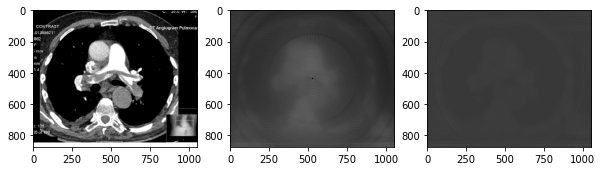

In [5]:
test('img/SADDLE_PE.JPG', nDetectors=100, deltaAlfa=2, spreadDetectors=90,x=0,filtering=1,plot=True)

0 rmse no filtering  0.410687
rmse filtering     0.232323


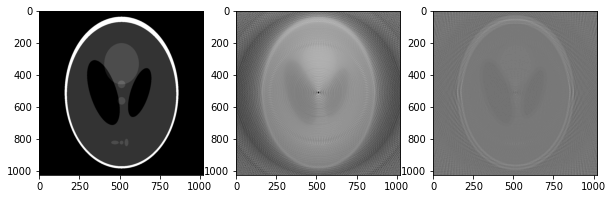

In [6]:
test('img/Shepp_logan.jpg',  nDetectors=100, deltaAlfa=2, spreadDetectors=90,x=0,filtering=1,plot=True)

180 rmse 0.480850


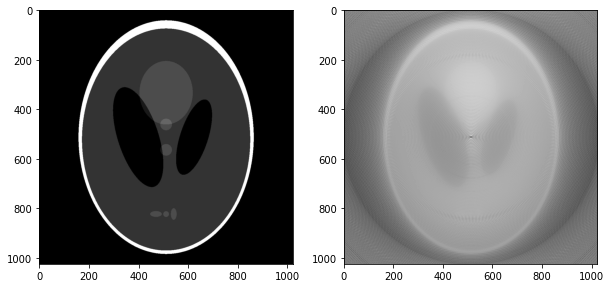

In [8]:
output, loss = test('img/Shepp_logan.jpg', 180, 1, 270,180, False,  plot=True)
print(f'rmse {loss:.6f}')

In [8]:
imgn =[]
imga = []
imgl =[]
rmsen = []
rmsea =[]
rmsel =[]

In [9]:
for x in detec:
    o, r = test('img/SADDLE_PE.JPG', x, alfa, l, x, False) 
    imgn.append(o)
    rmsen.append(r)

90 180 270 360 450 540 630 720 

In [10]:
for x in scans:
    o, r = test('img/SADDLE_PE.JPG',n, x, l,x, False) 
    imga.append(o)
    rmsea.append(r)

4.0 2.0 1.3333333333333333 1.0 0.8 0.6666666666666666 0.5714285714285714 0.5 

In [11]:
for x in angle:
    o, r = test('img/SADDLE_PE.JPG',n, alfa, x,x, False) 
    imgl.append(o)
    rmsel.append(r)

45 90 135 180 225 270 

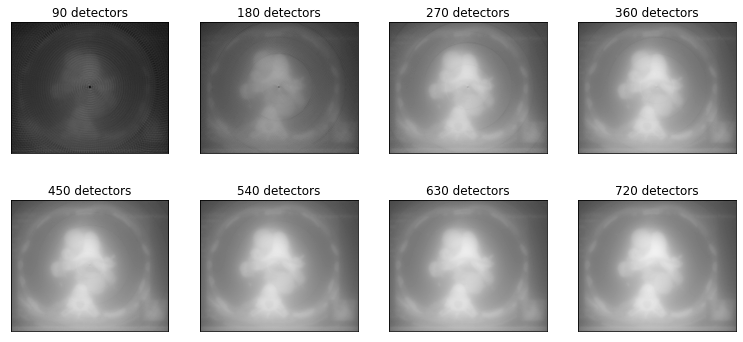

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(13, 6))
axs = np.array(axs).reshape(-1)
for i, x in enumerate(detec):
    axs[i].imshow(imgn[i], cmap='gray')
    axs[i].set_xticks([]); axs[i].set_yticks([])
    axs[i].set_title(f'{x} detectors')
save(fig,'n detectors1')

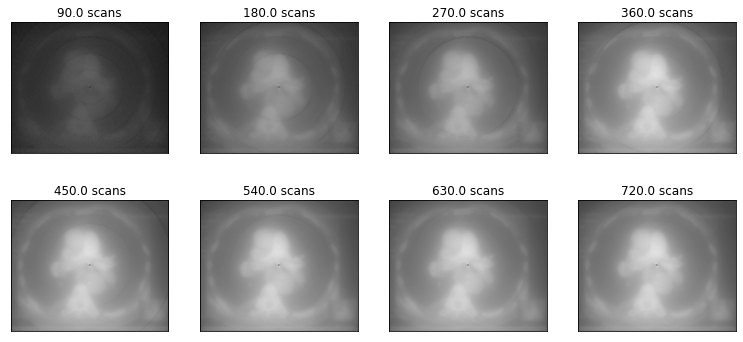

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(13, 6))
axs = np.array(axs).reshape(-1)
for i, x in enumerate(scans):
    axs[i].imshow(imga[i], cmap='gray')
    axs[i].set_xticks([]); axs[i].set_yticks([])
    axs[i].set_title(f'{360/x} scans')
save(fig,'alfa scans1')

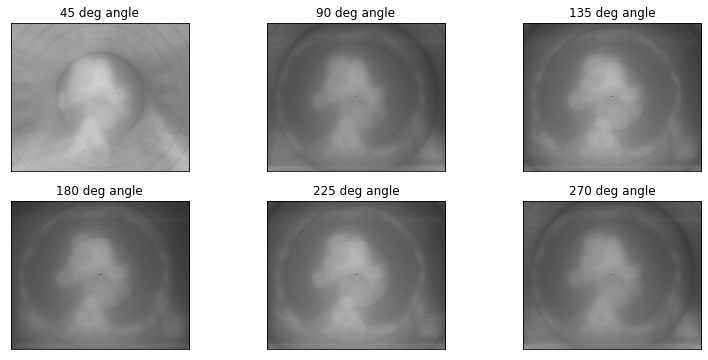

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))
axs = np.array(axs).reshape(-1)
for i, x in enumerate(angle):
    axs[i].imshow(imgl[i], cmap='gray')
    axs[i].set_xticks([]); axs[i].set_yticks([])
    axs[i].set_title(f'{x} deg angle')
save(fig,'l deg angle11')

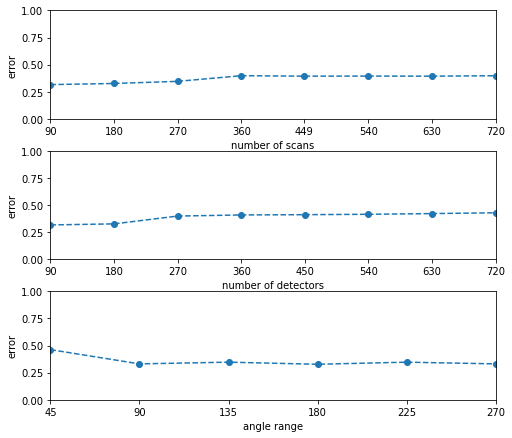

In [12]:
def plot_axis(ax, xs, ys, xlabel='', ylabel=''):
    ax.plot(xs, ys, marker='o', linestyle='--')
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel) 
    ax.set_xlim(np.min(xs), np.max(xs)); ax.set_ylim(0, 1)
    ax.set_xticks(xs); ax.set_yticks(np.linspace(0, 1, 5))
    
# import seaborn as sns
# sns.set_style('white')
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex=False, figsize=(7, 6))
fig.tight_layout()
plot_axis(ax1, 360//scans, rmsea, xlabel='number of scans', ylabel='error')
plot_axis(ax2, detec, rmsen, xlabel='number of detectors', ylabel='error')
plot_axis(ax3, angle, rmsel, xlabel='angle range', ylabel='error')
plt.show()
save(fig,'rmse1')